In [1]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import awkward1 as ak
from lxml import etree as ET
import os
from pathlib import Path
import pandas as pd
import numpy as np

from event_display import get_module_geometry, get_module_positions, plot_calorimeter_hits, build_calorimeter_section
import bokeh

In [2]:
# Load geometry file
geometry_xml = ET.parse(f"{Path.cwd()}/test/geometry/athena.gdml")

# Data file name
data_file_name = f"{Path.cwd()}/test/dd4pod_example_data/test_1000evt_gamma_1x_31y_0z_5.0GeV.root"

# Number of events to process:
start_event=1
process_events=1


In [3]:
pwo_size_x, pwo_size_y, pwo_size_z, unit = get_module_geometry('crystal_box', geometry_xml)
print(f"PWO module size: size_x={pwo_size_x:.2f}{unit} size_y={pwo_size_y:.2f}{unit} size_z={pwo_size_z:>.2f}{unit}")

pos_by_id = get_module_positions('crystal_module', geometry_xml)
print(f"Total PWO modules: {len(pos_by_id)}")

PWO module size: size_x=20.00mm size_y=20.00mm size_z=200.00mm
Total PWO modules: 1104


In [4]:
id_values = []
x_values = []
y_values = []

for cell_id, xy in pos_by_id.items():
    id_values.append(cell_id)
    x_values.append(xy[0])
    y_values.append(xy[1])

module_df = pd.DataFrame({"id":id_values, "x":x_values, "y":y_values})
module_df




,id,x,y
0,93871021921904,-71.75,-399.75
1,93871021922144,-51.25,-399.75
2,93871021922384,-71.75,-379.25
3,93871021922624,-51.25,-379.25
4,93871021922864,-30.75,-399.75
...,...,...,...
1099,93871027272384,30.75,399.75
1100,93871027272624,51.25,379.25
1101,93871027272864,71.75,379.25
1102,93871027273104,51.25,399.75


In [5]:
def find_argmin_distance(df, x, y):
    distance = np.sqrt((df.x-x)**2 + (df.y-y)**2)
    return np.argmin(distance)

idx = find_argmin_distance(module_df, 10, 215)
module_df.iloc[[idx]]

,id,x,y
912,93871027198224,10.25,215.25


In [15]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.plotting import ColumnDataSource, figure, show, output_file
output_notebook()


Loading BokehJS ...

In [18]:
def bokeh_build_calorimeter_section(df, size_x, size_y):
    dx = size_x / 2.0
    dy = size_y / 2.0

    # instantiating the figure object

    source = ColumnDataSource(data=dict(
         id=df["id"],
         x=df["x"],
         y=df["y"]
    ))

    tooltips = [
        ("cell id", "@id"),
        ("(x,y)", "($x, $y)"),
        ("cell x,y", "(@x, @y)"),
        
    ]

    graph = figure(title = "Bokeh Rectangle Graph", match_aspect = True, tooltips = tooltips)

    graph.rect("x", "y", size_x, size_y, fill_alpha=0.2, source=source)

    return graph
      
     
graph = bokeh_build_calorimeter_section(module_df, pwo_size_x, pwo_size_y)
      
# displaying the model
#show(graph)

RuntimeError: 

Expected x and y to reference fields in the supplied data source.

When a 'source' argument is passed to a glyph method, values that are sequences
(like lists or arrays) must come from references to data columns in the source.

For instance, as an example:

    source = ColumnDataSource(data=dict(x=a_list, y=an_array))

    p.circle(x='x', y='y', source=source, ...) # pass column names and a source

Alternatively, *all* data sequences may be provided as literals as long as a
source is *not* provided:

    p.circle(x=a_list, y=an_array, ...)  # pass actual sequences and no source



In [8]:
file_name = "test/dd4pod_example_data/test_1000evt_gamma_1x_31y_0z_1.0GeV.root"
events_tree = uproot4.open(file_name)["events/EcalEndcapNHits/"]
events_tree.keys()  


['EcalEndcapNHits.cellID',
 'EcalEndcapNHits.flag',
 'EcalEndcapNHits.g4ID',
 'EcalEndcapNHits.position.x',
 'EcalEndcapNHits.position.y',
 'EcalEndcapNHits.position.z',
 'EcalEndcapNHits.position.t',
 'EcalEndcapNHits.truth.trackID',
 'EcalEndcapNHits.truth.pdgID',
 'EcalEndcapNHits.truth.deposit',
 'EcalEndcapNHits.truth.time',
 'EcalEndcapNHits.truth.length',
 'EcalEndcapNHits.truth.x',
 'EcalEndcapNHits.truth.y',
 'EcalEndcapNHits.truth.z',
 'EcalEndcapNHits.energyDeposit']

In [12]:
#hit_x = events_tree['EcalEndcapNHits.truth.x'].array()
#hit_y = events_tree['EcalEndcapNHits.truth.y'].array()

hit_x = events_tree['EcalEndcapNHits.position.x'].array()
hit_y = events_tree['EcalEndcapNHits.position.y'].array()
graph.scatter(ak.flatten(hit_x).to_numpy(), ak.flatten(hit_y).to_numpy(), size=1, color="red")
      
# displaying the model
show(graph)

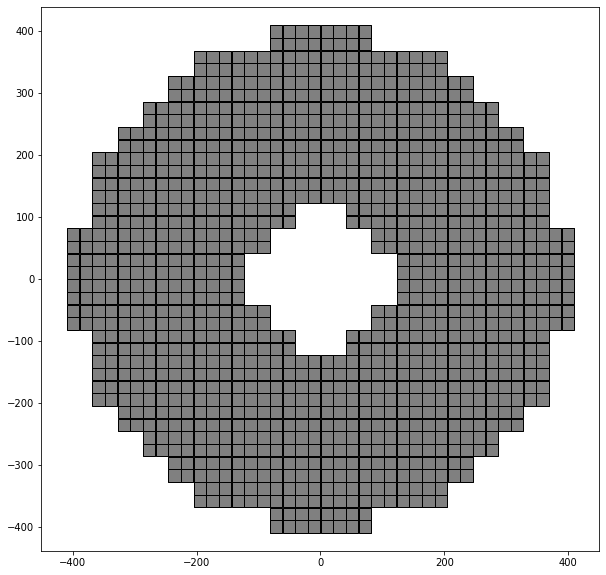

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
build_calorimeter_section(ax, pos_by_id.values(), pwo_size_x, pwo_size_y)
plt.show()

KeyInFileError: not found: 'ce_emcal_id'
in file /home/romanov/eic/hybrid_calorimeter_tools/test/dd4pod_example_data/test_1000evt_gamma_1x_31y_0z_5.0GeV.root
in object /events;1

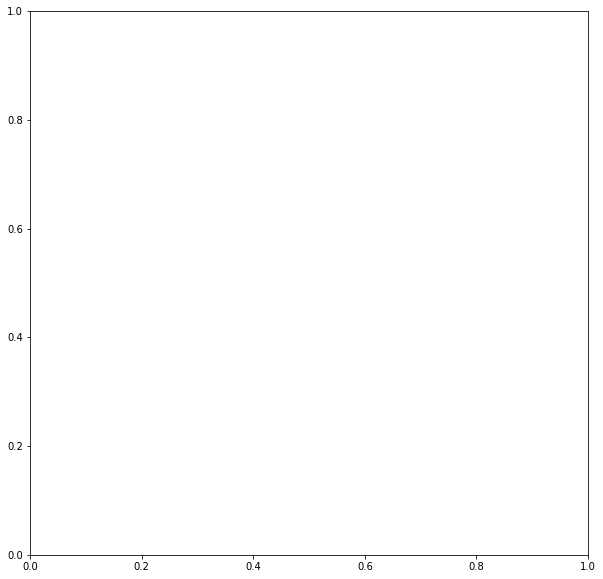

In [11]:
# Open file and get hits in events
root_file = uproot4.open(data_file_name)
fig, ax = plt.subplots(figsize=(10,10))

norm, cmap, _ = plot_calorimeter_hits(root_file, ax, pos_by_id, pwo_size_x, pwo_size_y, start_event, process_events)

ax.axis('equal')
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()


